In [1]:
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv("data.csv")

### Variable	Description
1. Item_Identifier	Id продукта
2. Item_Weight	Вес продукта
3. Item_Fat_Content	Содержание жира в продукте
4. Item_Visibility	%полок, отведенный под наш продукт в конкретном магазине
5. Item_Type	Категория продукта
6. Item_MRP	Максимальная цена продажи продукта
7. Outlet_Identifier	Идентификатор магазина
8. Outlet_Establishment_Year	Год открытия магазина
9. Outlet_Size	Площадь магазина
10. Outlet_Location_Type	Тип города, в котором расположен магазин
11. Outlet_Type	Признак является ли магазин продуктовым или супермаркетом
12. Item_Outlet_Sales	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

# EDA

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
numerical_feats = data.dtypes[data.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = data.dtypes[data.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  5
Number of Categorical features:  7


In [5]:
data[numerical_feats].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Заполнение пропусков

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


2 признака имеют пропущенные значения: Item_Weight (типа float), Outlet_Size (типа object)

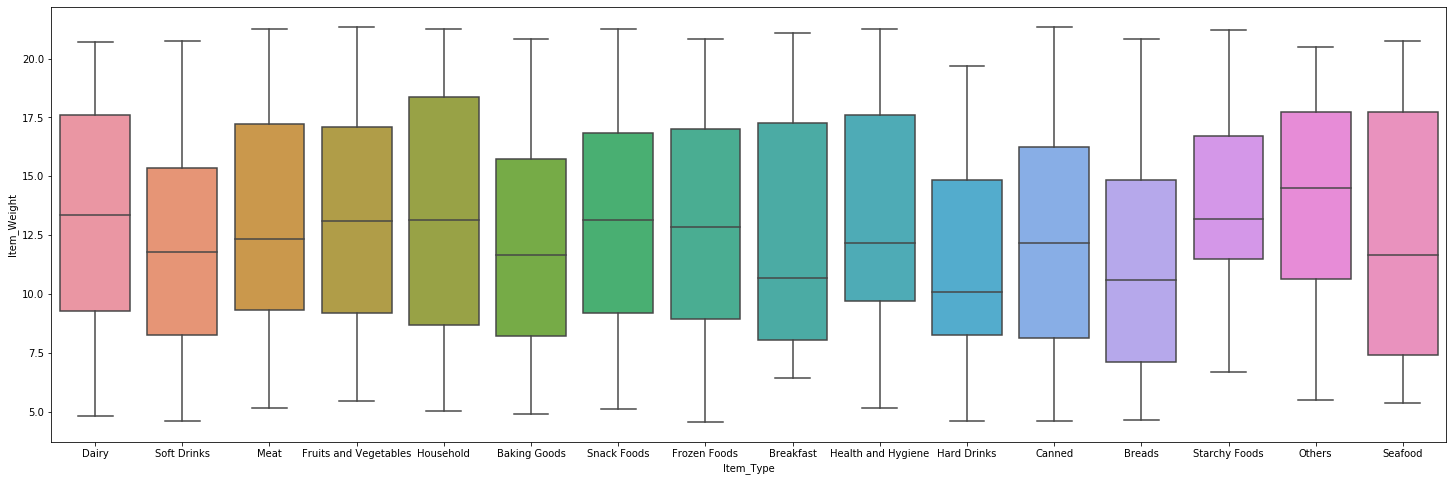

In [7]:
plt.figure(figsize=(25,8))
sns.boxplot(x='Item_Type',y='Item_Weight',data = data)

Распределение веса продукта относительно его категории поможет заполнить пустые значения в Item_Type, возьмем средний вес в категории продукта

In [8]:
data['Outlet_Size']=data['Outlet_Size'].replace({'Small':1, 'Medium':2, 'High':3})

Отранжируем размер магазина, пустые данные заполним модой относительно типа магазина

In [9]:
data["Item_Weight"] = data.groupby(["Item_Type"])["Item_Weight"].transform(lambda x: x.fillna(x.mean()))
data["Outlet_Size"] = data.groupby(["Outlet_Type"])["Outlet_Size"].transform(lambda x: x.fillna(x.mode()[0]))

# Продолжение EDA

Посмотрим корреляцию количественных признаков

In [10]:
df_num_corr = data[numerical_feats].corr()['Item_Outlet_Sales'][:-1]
df_num_corr.sort_values(ascending=False) 

Item_MRP                     0.567574
Item_Weight                  0.012088
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

Видно, что цена продажи продукта больше всех коррелирует с продажей продукта

In [11]:
data["Outlet_Year"] = 2020- data["Outlet_Establishment_Year"] 
#Преобразуем год открытия магазина в "Сколько лет работает магазин"

### Работа с категориальными признаками

In [12]:
data[categorical_feats].apply(lambda x : len(x.unique()))
# Посмотрим количество уникальных значений в категориальных признаках

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [13]:
data['Item_Identifier'].value_counts()

FDG33    10
FDW13    10
FDW26     9
DRE49     9
FDD38     9
         ..
FDO33     1
FDE52     1
DRF48     1
FDY43     1
FDK57     1
Name: Item_Identifier, Length: 1559, dtype: int64

Признак 'Item_Identifier' имеет очень много значений.
Первые две буквы в идентификационном номере могут означать тип еды, сделаем его отдельным признаком 'Item_Type_lite', это может иметь связь

In [14]:
data['Item_Type_lite'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_lite'].value_counts()

FD    6125
NC    1599
DR     799
Name: Item_Type_lite, dtype: int64

In [15]:
print(data['Item_Fat_Content'].value_counts())

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Признак "Содержание жира" имеет всего две категории: Low Fat и Regular, но написаны разными способами, нужно привести к единому значению

In [16]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Посмотрим на корреляцию категориальных признаков

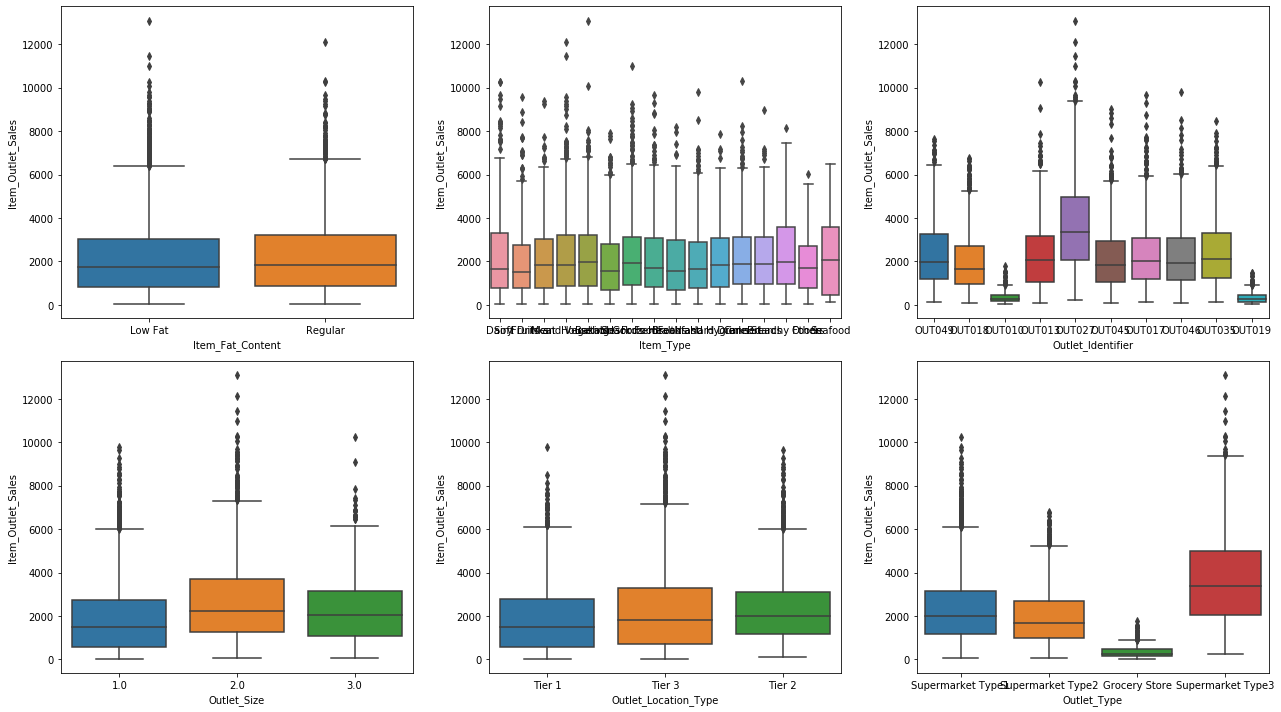

In [17]:
li_cat_feats = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*5))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=data['Item_Outlet_Sales'], data=data, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

На графиках боксплота видно, что тип магазина явно влияет на продажу продукта

In [18]:
y = data["Item_Outlet_Sales"]
data = data.drop(columns="Item_Identifier")
data = data.drop(columns="Outlet_Identifier")
data = data.drop(columns="Outlet_Establishment_Year")
data = data.drop(columns="Item_Outlet_Sales")

In [19]:
numerical_feats = data.dtypes[data.dtypes != "object"].index
categorical_feats = data.dtypes[data.dtypes == "object"].index

Для работы с категориальными переменными мы будем использовать get_dummies

In [20]:
dummy_data = pd.get_dummies(data, columns=list(categorical_feats))

In [21]:
dummy_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_lite_DR,Item_Type_lite_FD,Item_Type_lite_NC
0,9.30,0.016047,249.8092,2.0,21,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,5.92,0.019278,48.2692,2.0,11,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,17.50,0.016760,141.6180,2.0,21,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,19.20,0.000000,182.0950,1.0,22,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
4,8.93,0.000000,53.8614,3.0,33,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dummy_data, y, test_size = 0.2)
# разбиваем выборку

Отнормируем данные

In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train.loc[:,numerical_feats] = sc.fit_transform(X_train[numerical_feats])
X_test.loc[:,numerical_feats] = sc.fit_transform(X_test[numerical_feats])

C:\Users\orudkovskaya\AppData\Local\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\orudkovskaya\AppData\Local\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
X_train

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_lite_DR,Item_Type_lite_FD,Item_Type_lite_NC
7462,-0.418321,-1.280569,0.398874,0.672950,-1.335188,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
188,1.626478,-0.933593,0.627751,-0.793857,-0.494302,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
7894,-0.418321,-1.075796,-0.928999,0.672950,-0.133922,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
6015,0.083959,0.752382,0.551642,0.672950,1.547850,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2949,0.083959,0.929530,-1.332638,0.672950,1.547850,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7001,0.338136,-0.326151,1.154197,-0.793857,0.106331,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
5209,-0.359947,-0.811641,-0.619141,0.672950,1.547850,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
1259,1.685576,0.645745,0.464262,-0.793857,-0.013796,0,1,1,0,0,...,0,0,1,1,0,0,0,0,1,0
5591,0.149022,-0.218081,-1.708434,-0.793857,-1.094935,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


# Обучение линейной моделью

Метрика качества для обучения выбрана MAE, поскольку есть много выбросов, которые могут негативно влиять на модель

### Ridge

In [25]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
params_ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0]}

In [27]:
reg_ridge = GridSearchCV(Ridge(),params_ridge,cv=5,scoring ='neg_mean_absolute_error')

reg_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [28]:
print(reg_ridge.best_score_,
      reg_ridge.best_params_,
      reg_ridge.best_estimator_)

-835.1243112700176 {'alpha': 1} Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [29]:
ridge = reg_ridge.best_estimator_

In [30]:
ridge.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [31]:
r2_ridge = r2_score(y_test, ridge.predict(X_test))

In [32]:
mse_ridge = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))

In [33]:
mae_ridge = np.sqrt(mean_absolute_error(y_test, ridge.predict(X_test)))

### SGD

In [34]:
from sklearn.linear_model import SGDRegressor

In [35]:
params_SGDR = {'loss': ['squared_loss', 'huber','epsilon_insensitive', 'squared_epsilon_insensitive'],
              'penalty': ['l2', 'l1', 'elasticnet'],
               'alpha': [1,0.1,0.01,0.001,0.0001],
              'max_iter': [100,1000,10000]}

In [36]:
search_sgd = RandomizedSearchCV(SGDRegressor(),params_SGDR,scoring='neg_mean_absolute_error',cv=5, n_jobs=6, n_iter = 10)
search_sgd.fit(X_train,y_train)


print(search_sgd.best_score_,search_sgd.best_params_)
print(search_sgd.best_estimator_)

-835.5794939792271 {'penalty': 'l1', 'max_iter': 1000, 'loss': 'squared_epsilon_insensitive', 'alpha': 0.0001}
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=1000, n_iter_no_change=5, penalty='l1', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [37]:
SGD = search_sgd.best_estimator_

In [38]:
SGD.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=1000, n_iter_no_change=5, penalty='l1', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
np.sqrt(mean_squared_error(y_test, SGD.predict(X_test)))

1146.0265244355953

In [40]:
r2_score(y_test, SGD.predict(X_test))

0.5732244015859249

# Обучение нелинейной моделью

### Случайный лес

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
params_rf = {'n_estimators' : [100,200,500,800,1000,1200],
           'max_depth' : [3,5,7,10,15,25,40,None],
           'min_samples_split':[2,4,6,10],
           'min_samples_leaf':[2,4,6,8]   
           }

search_rfr = RandomizedSearchCV(RandomForestRegressor(), params_rf, scoring='neg_mean_absolute_error',cv=5, n_jobs=6, n_iter = 10)
search_rfr.fit(X_train,y_train)


print(search_rfr.best_params_)
print(search_rfr.best_estimator_)

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 7}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [43]:
RFR = search_rfr.best_estimator_
RFR.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
r2_rf = r2_score(y_test, RFR.predict(X_test))

In [45]:
mse_rf = np.sqrt(mean_squared_error(y_test, RFR.predict(X_test)))

In [46]:
mae_rf = np.sqrt(mean_absolute_error(y_test, RFR.predict(X_test)))

### Дерево решений

In [47]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
params_tree = {'max_depth' : [3,5,7,10,15,25,40,None],
           'min_samples_split':[2,4,6,10,20,30],
           'min_samples_leaf':[1,2,4,6,8],
#           'max_features': [None, 5, 10, 15],
            'random_state': [5]
           }

search_tree = RandomizedSearchCV(DecisionTreeRegressor(), params_tree, scoring='neg_mean_absolute_error',cv=5, n_jobs=6, n_iter = 10)
search_tree.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [49]:
print(search_tree.best_score_,
      search_tree.best_params_)
print(search_tree.best_estimator_)

-763.5528691803985 {'random_state': 5, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_depth': 5}
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=5, splitter='best')


In [50]:
tree = search_tree.best_estimator_
tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=5, splitter='best')

In [51]:
r2_tree = r2_score(y_test, tree.predict(X_test))

In [52]:
mse_tree = np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))

In [53]:
mae_tree = np.sqrt(mean_absolute_error(y_test, tree.predict(X_test)))

# Стекинг

In [54]:
from sklearn.ensemble import StackingRegressor

In [55]:
stec_reg = StackingRegressor(
     [('Ridge', reg_ridge.best_estimator_),
      ('SGD', search_sgd.best_estimator_),
      ('tree', search_tree.best_estimator_)
    ],
search_rfr.best_estimator_)
#Подкапотные алгоритмы - линейные алгоритмы и дерево решений, финальный алгоритм - случайный лес

In [56]:
stec_reg.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('Ridge',
                               Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0.001)),
                              ('SGD',
                               SGDRegressor(alpha=0.0001, average=False,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.01, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='invscaling',
                                            loss='squared_epsilon_insensitive'...
                  final_estimator=RandomForestRegressor(bootstrap=True,
                                                        ccp_alpha=0.0,
                                           

In [57]:
r2_stec = r2_score(y_test, stec_reg.predict(X_test))

In [58]:
mse_stec = np.sqrt(mean_squared_error(y_test, stec_reg.predict(X_test)))

In [59]:
mae_stec = np.sqrt(mean_absolute_error(y_test, stec_reg.predict(X_test)))

### Важность признаков

Ellipsis

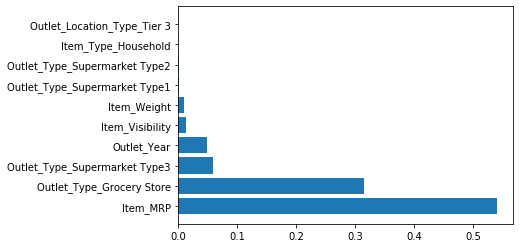

In [60]:
fi = pd.DataFrame(zip(RFR.feature_importances_, X_train.columns)).sort_values([0], ascending=False).head(10)
plt.barh(np.arange(len(fi[0])), fi[0])
plt.yticks(np.arange(len(fi[1])),fi[1])
...

Наиболее важные признаки получились: Максимальная цена продажи продуктов, тип магазина, сколько лет работает магазин

### Сравнение алгоритмов

In [63]:
print (f"R2_score  : Tree={r2_tree:.3f},    RF={r2_rf:.3f},     RIDGE={r2_ridge:.3f},    ST={r2_stec:.3f}")
print (f"MSE       : Tree={mse_tree:.3f}, RF={mse_rf:.3f},  RIDGE={mse_ridge:.3f}, ST={mse_stec:.3f}")
print (f"MAE       : Tree={mae_tree:.3f},   RF={mae_rf:.3f},    RIDGE={mae_ridge:.3f},   ST={mae_stec:.3f}")

R2_score  : Tree=0.619,    RF=0.617,     RIDGE=0.573,    ST=0.613
MSE       : Tree=1082.130, RF=1086.203,  RIDGE=1145.684, ST=1091.462
MAE       : Tree=27.707,   RF=27.706,    RIDGE=29.242,   ST=27.832


Алгоритм Случайный лес показал лучшие результаты, хотя остальные используемые алгоритмы были близки к нему